In [1]:
'''
* create idealized 0-D model with only "ENSO" effect (only change the gmst; t1/t2 just use the target results)
* the "ENSO" frequency: could be single frq. or red noise
'''

import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import xarray as xr

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# import subroutine to read file from model output and controller
sys.path.insert(1, '../') 
from read_file import *
from cal_IVs import *


In [2]:
#============================================#
# calculate model sensitivity based on ARISE and SSP245 runs
#============================================#

#----- load existing data or calculating from model output -----#
path = '/glade/u/home/dchenrui/DARPA/controller_to_0D_model/'
fname = '0D-model_sensitivity.nc'

# if fname not in os.listdir(path):
print('sensitivity profile does not exit, collecting data from model...')

#--- read data from SAI, SSP, and controller log ---#
PATH = "/glade/campaign/cesm/collections/ARISE-SAI-1.5/"
CASE = "b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT."
time_span = ['2035', '2069']
t_sai = read_data("TREFHT", PATH, CASE, time_span)

PATH = "/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/"
CASE = "b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM."
print('read SSP245')
t_ssp = read_data("TREFHT", PATH, CASE, time_span)

PATH = "/glade/campaign/cesm/collections/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT." 
t0, t1, t2, so2 = read_sai(PATH)

#--- calculate gmst ---#
def cal_gmst(t, freq='ann'):
    tavg = t.mean('ens')

    if freq == 'ann':
        t_ann = tavg.groupby('time.year').mean('time')
    else:
        t_ann = tavg

    weights = np.cos(np.deg2rad(t.lat))
    weights.name = "weights"
    gmst = t_ann.weighted(weights).mean(("lat", "lon"))

    return gmst

gmst_sai = cal_gmst(t_sai)
gmst_ssp = cal_gmst(t_ssp)
gmst_ssp_m = cal_gmst(t_ssp,'mon')

sai = so2.sel(year = slice(0, 2064)).sum('loc', keep_attrs=True).mean('ens')

#--- linear fit between total injection and gmst ---#
delta_gmst = gmst_ssp - gmst_sai
sens,res = np.polyfit(sai, delta_gmst, 1) 


# #--- save sensitivity related data to files ---#
# print('writing sensitivity profile to netcdf...')
# ds = xr.merge([gmst_ssp.to_dataset(name = 'gmst_ssp'), 
#                gmst_sai.sel(year = slice(0, 2064)).to_dataset(name = 'gmst_sai'), 
#                gmst_ssp_m.to_dataset(name = 'gmst_ssp_mon'), 
#                so2.sel(year = slice(0, 2064)).to_dataset(name = 'so2'),
#                xr.DataArray(sens).to_dataset(name = 'sensitivity'),
#                xr.DataArray(res).to_dataset(name = 'residule')])
# ds.assign_coords({'year': ds.year.astype(int)})
# ds.to_netcdf(path = path+fname)

# else: 
    
#     print('loading sensitivity profile from netcdf...')

#     ds = xr.open_dataset(path+fname)
#     delta_gmst = ds.gmst_ssp - ds.gmst_sai
#     gmst_ssp_m = ds.gmst_ssp_mon
#     sai = ds.so2.sum('loc', keep_attrs=True).mean('ens')
#     sens = ds.sensitivity
#     res = ds.residule
    

#----- activate model sensitivty module -----#
def sai_cool(total_sai):
    return total_sai*sens*-1.0

sensitivity profile does not exit, collecting data from model...
read TREFHT in case:1
read TREFHT in case:2
read TREFHT in case:3
read TREFHT in case:4
read TREFHT in case:5
read TREFHT in case:6
read TREFHT in case:7
read TREFHT in case:8
read TREFHT in case:9
read TREFHT in case:10
read SSP245
read TREFHT in case:1
read TREFHT in case:2
read TREFHT in case:3
read TREFHT in case:4
read TREFHT in case:5
read TREFHT in case:6
read TREFHT in case:7
read TREFHT in case:8
read TREFHT in case:9
read TREFHT in case:10
read SAI in case1: ControlLog_b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001.txt
read SAI in case2: ControlLog_b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002.txt
read SAI in case3: ControlLog_b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003.txt
read SAI in case4: ControlLog_b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004.txt
read SAI in case5: ControlLog_b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005.txt
read SAI in case6: ControlLog_b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAU

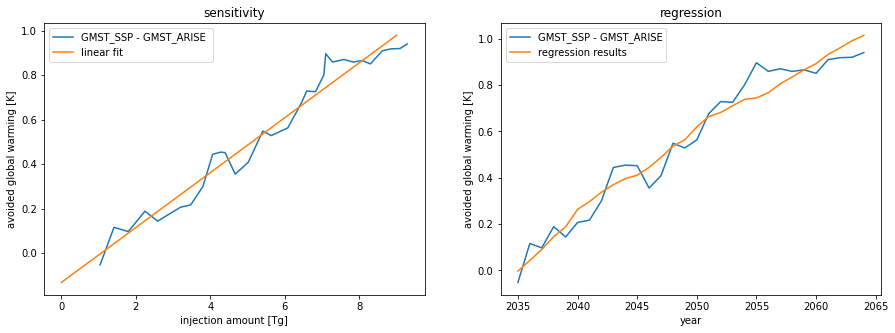

In [3]:
#============================================#
# Plot: 0-D model sensitivity to SAI 
#============================================#

plt.figure(figsize=(15,5)) 
ax = plt.subplot(1, 2, 1)

plt.plot(sai, delta_gmst, label = "GMST_SSP - GMST_ARISE ")
plt.plot(np.arange(0, 10)*float(sens) + float(res), label= 'linear fit')
plt.title('sensitivity')
plt.xlabel('injection amount [Tg]')
plt.ylabel('avoided global warming [K]')
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(delta_gmst.year, delta_gmst, label = 'GMST_SSP - GMST_ARISE')
plt.plot(delta_gmst.year, sai*sens + res, label = 'regression results')
plt.title('regression')
plt.xlabel('year')
plt.ylabel('avoided global warming [K]')
plt.legend()

# plt.savefig('../figs/FigS1.pdf', dpi=300)


ENSO magnitude: <xarray.DataArray ()>
array(0.25)
percentage increase:  <xarray.DataArray ()>
array(3.10795665)
<xarray.DataArray ()>
array(5.87275063)


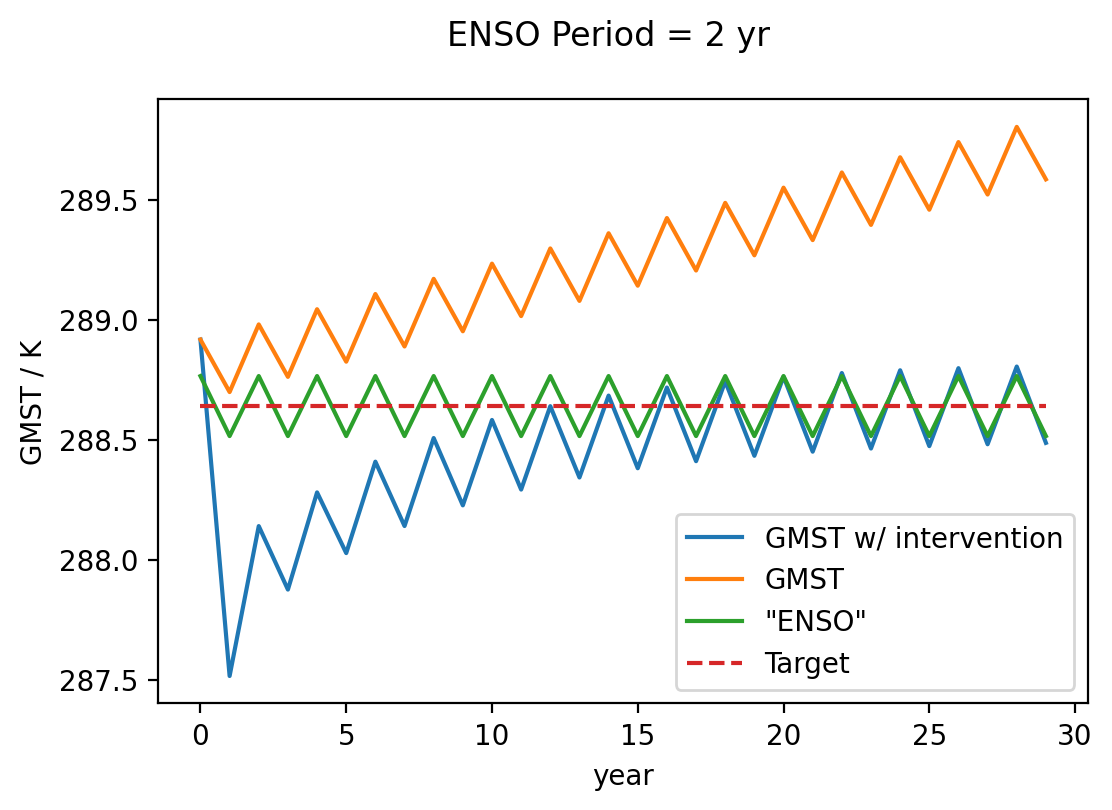

In [4]:
#============================================#
# create T0: T0 = global warming + simulated "ENSO" based on sin function
#============================================#

# linear warming due to GHGs
length = len(gmst_ssp_m.time)
time = np.arange(0,length,1)
warm_rate, initial_temp = np.polyfit(time, gmst_ssp_m, 1)
gmst_lin = xr.DataArray(time*warm_rate + initial_temp, 
                        dims = 'time',
                        coords = {'time':gmst_ssp_m.time},
                        attrs=dict(units = 'K',)
                       )
                        

# simulated ENSO
def gmst_enso(period, mag=0.2):
    '''
    period: period in months
    mag: magnitude of gmst fluctuation default to 0.2
    '''
    init_phase = 0.5*np.pi
    coef = 2.0 * np.pi / period
    
    length = len(gmst_ssp_m.time)
    time = np.arange(0,length,1)
    
    y = xr.DataArray(mag * np.sin(time * coef + init_phase),
                  dims = 'time',
                  coords = {'time':gmst_ssp_m.time},
                  attrs=dict(units = 'K',)
                 )
    return y

period, mag = 24, 1.5
# period, mag = 18, 0.37
# period, mag = 36, 0.1925
# period, mag = 84, 0.135

gmst_var_m = gmst_enso(period, mag)
gmst_var = gmst_var_m.groupby('time.year').mean('time')

gmst_m = gmst_var_m + gmst_lin
#gmst = gmst_m.groupby('time.year').mean('time')
gmst = gmst_var + gmst_lin.groupby('time.year').mean('time')

### MAIN

runname_0 = ['1yr-frq_global-warming']
runname = runname_0[0]

maindir = '/glade/u/home/dchenrui/DARPA/controller_to_0D_model/'

variables=['TREFHT']
archivepaths=len(variables)*['/glade/scratch/geostrat/archive/'+runname+'/atm/hist'] # do NOT include a '/' at the end of each path
varlocs=len(variables)*['cam.h0']

###########################
### CALLING MAIN SCRIPT ###
###########################|

pathtocontrol = maindir+'/PIcontrol_0D_cumulate-effect.py'
#pathtocontrol = maindir+'/PIcontrol_0D_simpler-feedback.py'

lag = 1 # controller's lag


length = len(gmst.year)
gmst_cool = gmst.copy()
gmst_ref = gmst.copy()
gmst_ref[:] = 288.64
s = gmst.copy()
s[:] = float("nan")

if os.path.exists('ControlLog_'+runname+'.txt')==True:
    os.remove('ControlLog_'+runname+'.txt')

T0 = gmst_cool[0]
for iyr in range(length-1):
    exec(open(pathtocontrol).read())
    
    gmst_cool[iyr+lag] = gmst[iyr+lag] + sai_cool(total_s)[0]
    T0 = gmst_cool[iyr+lag]
    s[iyr + lag] = total_s[0]
    
plt.figure(dpi=200)     
plt.plot(gmst_cool, label = 'GMST w/ intervention')
plt.plot(gmst, label = 'GMST')
plt.plot(gmst_var + gmst_ref, label = '"ENSO"')
plt.plot(gmst_ref,linestyle='--', label='Target')
plt.suptitle('ENSO Period = 2 yr')
plt.ylabel('GMST / K')
plt.xlabel('year')
plt.legend()

print('ENSO magnitude:', max(gmst_var) - min(gmst_var))
#print('diff: ', max(gmst_cool[5:]) - min(gmst_cool[5:]))
print('percentage increase: ', (max(gmst_cool[5:]) - min(gmst_cool[5:])) / (max(gmst_var) - min(gmst_var)))

print(gmst_cool.var() / gmst_var.var())

gmst_cool.to_netcdf('./gmst_cool.nc')
gmst.to_netcdf('./gmst.nc')
gmst_var.to_netcdf('./gmst_var.nc')
gmst_ref.to_netcdf('./gmst_ref.nc')

ENSO magnitude: <xarray.DataArray ()>
array(0.2502191)
percentage increase:  <xarray.DataArray ()>
array(4.30763937)


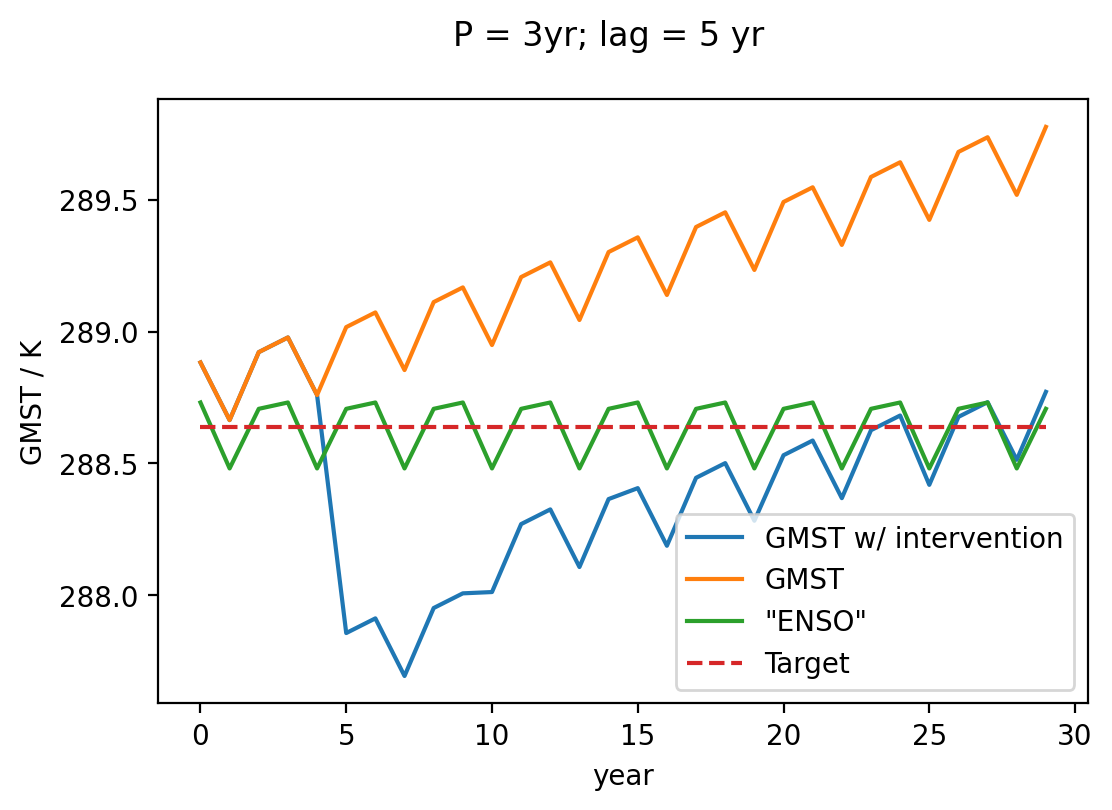

In [5]:
### create T0: T0 = global warming + simulated "ENSO" based on sin function

# linear warming due to GHGs
length = len(gmst_ssp_m.time)
time = np.arange(0,length,1)
warm_rate, initial_temp = np.polyfit(time, gmst_ssp_m, 1)
gmst_lin = xr.DataArray(time*warm_rate + initial_temp, 
                        dims = 'time',
                        coords = {'time':gmst_ssp_m.time},
                        attrs=dict(units = 'K',)
                       )
                        

# simulated ENSO
def gmst_enso(period, mag=0.2):
    '''
    period: period in months
    mag: magnitude of gmst fluctuation default to 0.2
    '''
    init_phase = 0.5*np.pi
    coef = 2.0 * np.pi / period
    
    length = len(t_ssp.time)
    time = np.arange(0,length,1)
    y = mag * np.sin(time * coef + init_phase)
    
    y = xr.DataArray(mag * np.sin(time * coef + init_phase),
                  dims = 'time',
                  coords = {'time':t_ssp.time},
                  attrs=dict(units = 'K',)
                 )
    return y

#period, mag = 24, 1.5
# period, mag = 18, 0.37
period, mag = 36, 0.1925
# period, mag = 84, 0.135

gmst_var_m = gmst_enso(period, mag)
gmst_var = gmst_var_m.groupby('time.year').mean('time')

gmst_m = gmst_var_m + gmst_lin
gmst = gmst_m.groupby('time.year').mean('time')

### MAIN

runname_0 = ['1yr-frq_global-warming']
runname = runname_0[0]

maindir = '/glade/u/home/dchenrui/DARPA/controller_to_0D_model/'

variables=['TREFHT']
archivepaths=len(variables)*['/glade/scratch/geostrat/archive/'+runname+'/atm/hist'] # do NOT include a '/' at the end of each path
varlocs=len(variables)*['cam.h0']

###########################
### CALLING MAIN SCRIPT ###
###########################|

pathtocontrol = maindir+'/PIcontrol_0D_cumulate-effect.py'
#pathtocontrol = maindir+'/PIcontrol_0D_simpler-feedback.py'

lag = 5 # controller's lag

length = len(gmst.year)
gmst_cool = gmst.copy()
gmst_ref = gmst.copy()
gmst_ref[:] = 288.64
s = gmst.copy()
s[:] = float("nan")

if os.path.exists('ControlLog_'+runname+'.txt')==True:
    os.remove('ControlLog_'+runname+'.txt')

T0 = gmst_cool[0: 0 + lag].mean('year')

for iyr in range(length//lag-1):
    exec(open(pathtocontrol).read())
    
    gmst_cool[int((iyr+1)*lag) : int((iyr+2)*lag)] = gmst[int((iyr+1)*lag) : int((iyr+2)*lag)] + sai_cool(total_s)[0]
    
    T0 = gmst_cool[int((iyr+1)*lag) : int((iyr+2)*lag)].mean('year')
    s[int((iyr+1)*lag) : int((iyr+2)*lag)] = total_s[0]
    
plt.figure(dpi=200)     
plt.plot(gmst_cool, label = 'GMST w/ intervention')
plt.plot(gmst, label = 'GMST')
plt.plot(gmst_var + gmst_ref, label = '"ENSO"')
plt.plot(gmst_ref,linestyle='--', label='Target')
plt.suptitle('P = 3yr; lag = '+ str(lag) +' yr')
plt.ylabel('GMST / K')
plt.xlabel('year')
plt.legend()

print('ENSO magnitude:', max(gmst_var) - min(gmst_var))
#print('diff: ', max(gmst_cool[5:]) - min(gmst_cool[5:]))
print('percentage increase: ', (max(gmst_cool[5:]) - min(gmst_cool[5:])) / (max(gmst_var) - min(gmst_var)))

ENSO magnitude: <xarray.DataArray ()>
array(0.2502191)
percentage increase:  <xarray.DataArray ()>
array(0.72652754)


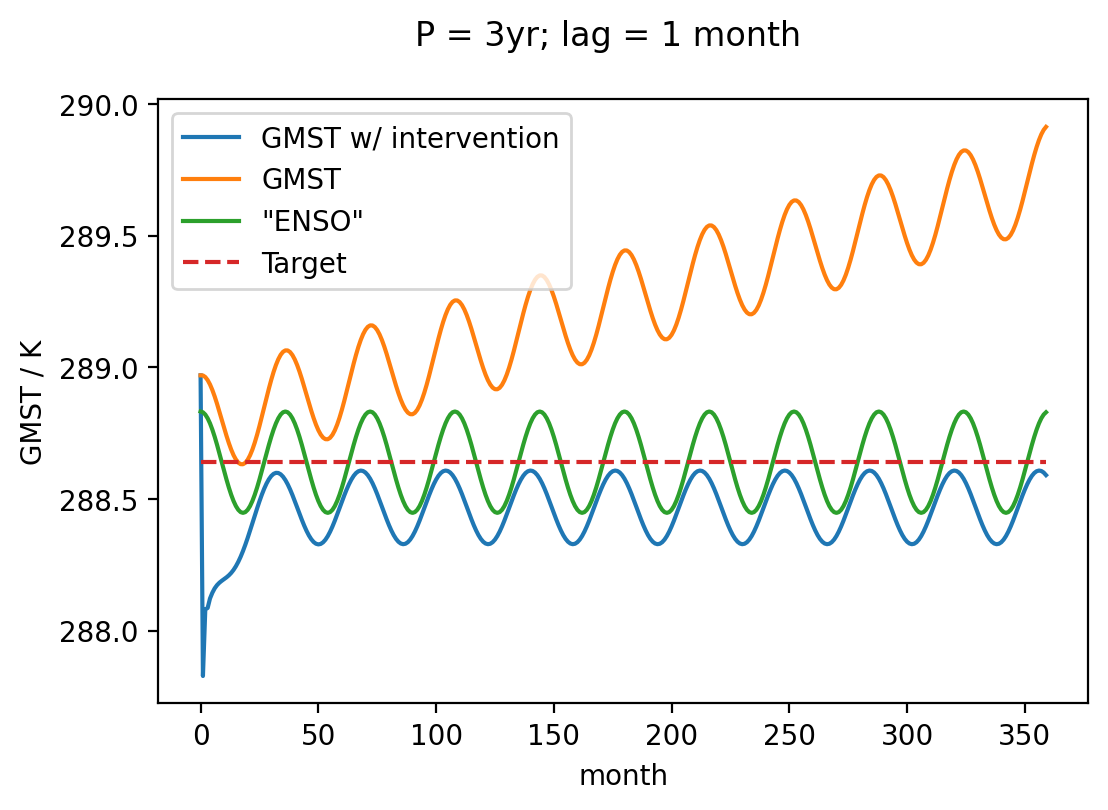

In [6]:
### create T0: T0 = global warming + simulated "ENSO" based on sin function

# linear warming due to GHGs
length = len(t_ssp.time)
time = np.arange(0,length,1)
warm_rate, initial_temp = np.polyfit(time, gmst_ssp_m, 1)
gmst_lin = xr.DataArray(time*warm_rate + initial_temp, 
                        dims = 'time',
                        coords = {'time':t_ssp.time},
                        attrs=dict(units = 'K',)
                       )
                        

# simulated ENSO
def gmst_enso(period, mag=0.2):
    '''
    period: period in months
    mag: magnitude of gmst fluctuation default to 0.2
    '''
    init_phase = 0.5*np.pi
    coef = 2.0 * np.pi / period
    
    length = len(t_ssp.time)
    time = np.arange(0,length,1)
    y = mag * np.sin(time * coef + init_phase)
    
    y = xr.DataArray(mag * np.sin(time * coef + init_phase),
                  dims = 'time',
                  coords = {'time':t_ssp.time},
                  attrs=dict(units = 'K',)
                 )
    return y

#period, mag = 24, 1.5
# period, mag = 18, 0.37
period, mag = 36, 0.1925
# period, mag = 84, 0.135

gmst_var_m = gmst_enso(period, mag)
gmst_var = gmst_var_m.groupby('time.year').mean('time')

gmst_m = gmst_var_m + gmst_lin
gmst = gmst_m.groupby('time.year').mean('time')

### MAIN

runname_0 = ['1yr-frq_global-warming']
runname = runname_0[0]

maindir = '/glade/u/home/dchenrui/DARPA/controller_to_0D_model/'

variables=['TREFHT']
archivepaths=len(variables)*['/glade/scratch/geostrat/archive/'+runname+'/atm/hist'] # do NOT include a '/' at the end of each path
varlocs=len(variables)*['cam.h0']

###########################
### CALLING MAIN SCRIPT ###
###########################|

pathtocontrol = maindir+'/PIcontrol_0D_cumulate-effect.py'
#pathtocontrol = maindir+'/PIcontrol_0D_simpler-feedback.py'

lag = 1 # controller's lag

length = len(gmst_m.time)
gmst_cool = gmst_m.copy()
gmst_ref = gmst_m.copy()
gmst_ref[:] = 288.64
s = gmst_m.copy()
s[:] = float("nan")

if os.path.exists('ControlLog_'+runname+'.txt')==True:
    os.remove('ControlLog_'+runname+'.txt')

T0 = gmst_cool[0: 0 + lag].mean('time')


for iyr in range(length//lag-1):
    exec(open(pathtocontrol).read())
    
    gmst_cool[int((iyr+1)*lag) : int((iyr+2)*lag)] = gmst_m[int((iyr+1)*lag) : int((iyr+2)*lag)] + sai_cool(total_s)[0]
    
    T0 = gmst_cool[int((iyr+1)*lag) : int((iyr+2)*lag)].mean('time')
    s[int((iyr+1)*lag) : int((iyr+2)*lag)] = total_s[0]
    
plt.figure(dpi=200)     
plt.plot(gmst_cool, label = 'GMST w/ intervention')
plt.plot(gmst_m, label = 'GMST')
plt.plot(gmst_var_m + gmst_ref, label = '"ENSO"')
plt.plot(gmst_ref,linestyle='--', label='Target')
plt.suptitle('P = 3yr; lag = '+ str(lag) +' month')
plt.ylabel('GMST / K')
plt.xlabel('month')
plt.legend()

print('ENSO magnitude:', max(gmst_var) - min(gmst_var))
#print('diff: ', max(gmst_cool[5:]) - min(gmst_cool[5:]))
print('percentage increase: ', (max(gmst_cool[60:]) - min(gmst_cool[60:])) / (max(gmst_var_m) - min(gmst_var_m)))

plot figs with lag= 1
ENSO magnitude: <xarray.DataArray ()>
array(0.2502191)
percentage increase:  <xarray.DataArray ()>
array(2.89749288)
plot figs with lag= 2
ENSO magnitude: <xarray.DataArray ()>
array(0.2502191)
percentage increase:  <xarray.DataArray ()>
array(3.19229173)
plot figs with lag= 5
ENSO magnitude: <xarray.DataArray ()>
array(0.2502191)
percentage increase:  <xarray.DataArray ()>
array(4.11988606)
ENSO magnitude: <xarray.DataArray ()>
array(0.2502191)
percentage increase:  <xarray.DataArray ()>
array(0.72652627)


Text(0.0, 1.0, '(d) lag = 1-month')

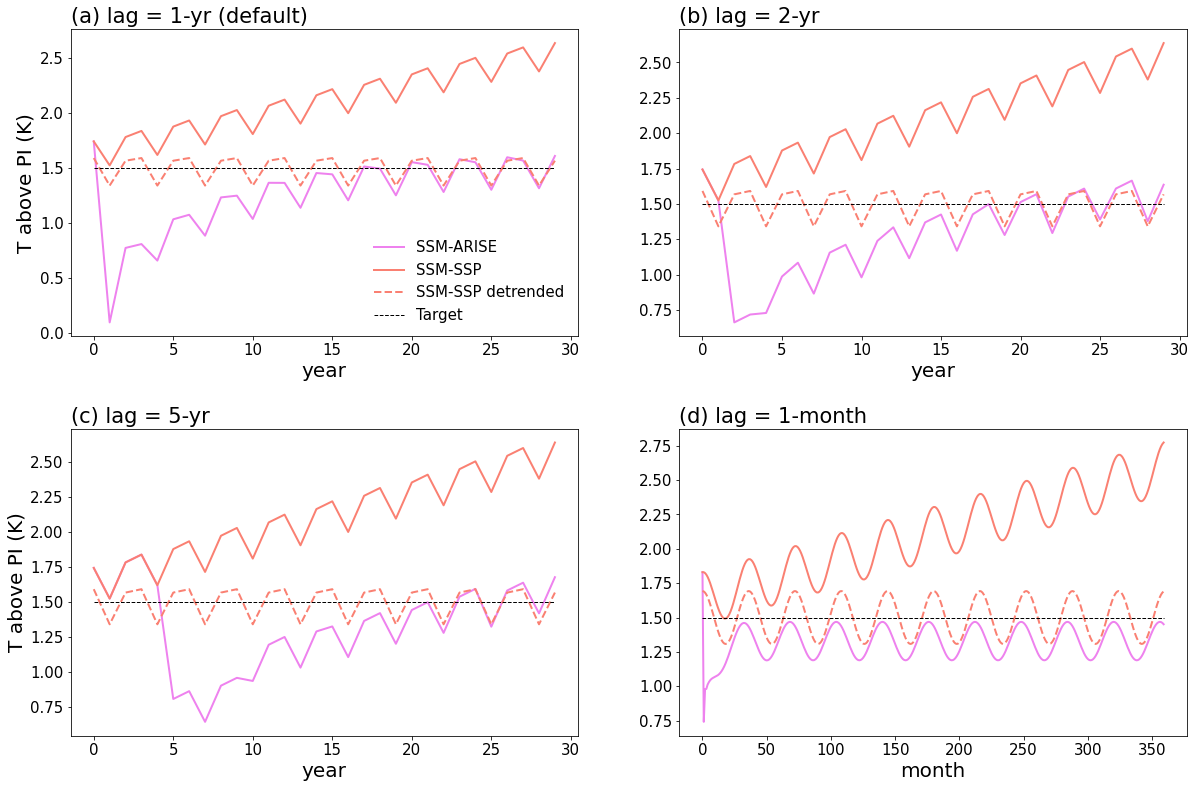

In [7]:
### Fig 6

# annual lags
pathtocontrol = maindir+'/PIcontrol_0D_cumulate-effect.py'

fig,ax = plt.subplots(2,2, figsize=(20, 13))
fig.subplots_adjust(hspace=0.3, wspace = 0.2)

lag_all = [1,2,5]

# variance plot embedded to the plot



for i in range(len(lag_all)):
    lag = lag_all[i] # controller's lag
    print('plot figs with lag=', str(lag))

    length = len(gmst.year)
    gmst_cool = gmst.copy()
    gmst_ref = gmst.copy()
    gmst_ref[:] = 288.64
    s = gmst.copy()
    s[:] = float("nan")

    if os.path.exists('ControlLog_'+runname+'.txt')==True:
        os.remove('ControlLog_'+runname+'.txt')

    T0 = gmst_cool[0: 0 + lag].mean('year')

    for iyr in range(length//lag-1):
        exec(open(pathtocontrol).read())

        gmst_cool[int((iyr+1)*lag) : int((iyr+2)*lag)] = gmst[int((iyr+1)*lag) : int((iyr+2)*lag)] + sai_cool(total_s)[0]

        T0 = gmst_cool[int((iyr+1)*lag) : int((iyr+2)*lag)].mean('year')
        s[int((iyr+1)*lag) : int((iyr+2)*lag)] = total_s[0]
    
    ax[i//2, i%2].plot(gmst_cool- 288.64 + 1.5, label = 'SSM-ARISE', linewidth = 2, c='violet')
    ax[i//2, i%2].plot(gmst - 288.64 + 1.5, label = 'SSM-SSP', linewidth = 2, c='salmon')
    ax[i//2, i%2].plot(gmst_var +1.5, label = 'SSM-SSP detrended', c='salmon', linestyle='--', linewidth = 2)
    ax[i//2, i%2].plot(gmst_ref - 288.64 + 1.5,linestyle='--', label='Target', c='k', linewidth = 1)
    if i == 0 or i ==2:
        ax[i//2, i%2].set_ylabel('T above PI (K)', size=20)
    
    ax[i//2, i%2].set_xlabel('year', size=20)
    ax[i//2, i%2].tick_params(axis='both', labelsize=15)
    
    # add legend
    if i ==0:
        ax[i//2, i%2].legend(fontsize=15, frameon=False)
    
    print('ENSO magnitude:', max(gmst_var) - min(gmst_var))
    #print('diff: ', max(gmst_cool[5:]) - min(gmst_cool[5:]))
    print('percentage increase: ', (max(gmst_cool[5:]) - min(gmst_cool[5:])) / (max(gmst_var) - min(gmst_var)))
    
# monthly lags
# linear warming due to GHGs
length = len(t_ssp.time)
time = np.arange(0,length,1)
warm_rate, initial_temp = np.polyfit(time, gmst_ssp_m, 1)
gmst_lin = xr.DataArray(time*warm_rate + initial_temp, 
                        dims = 'time',
                        coords = {'time':t_ssp.time},
                        attrs=dict(units = 'K',)
                       )
                        

# simulated ENSO
def gmst_enso(period, mag=0.2):
    '''
    period: period in months
    mag: magnitude of gmst fluctuation default to 0.2
    '''
    init_phase = 0.5*np.pi
    coef = 2.0 * np.pi / period
    
    length = len(t_ssp.time)
    time = np.arange(0,length,1)
    y = mag * np.sin(time * coef + init_phase)
    
    y = xr.DataArray(mag * np.sin(time * coef + init_phase),
                  dims = 'time',
                  coords = {'time':t_ssp.time},
                  attrs=dict(units = 'K',)
                 )
    return y

#period, mag = 24, 1.5
# period, mag = 18, 0.37
period, mag = 36, 0.1925
# period, mag = 84, 0.135

gmst_var_m = gmst_enso(period, mag)
gmst_var = gmst_var_m.groupby('time.year').mean('time')

gmst_m = gmst_var_m + gmst_lin
gmst = gmst_m.groupby('time.year').mean('time')

### MAIN

runname_0 = ['1yr-frq_global-warming']
runname = runname_0[0]

maindir = '/glade/u/home/dchenrui/DARPA/controller_to_0D_model/'

variables=['TREFHT']
archivepaths=len(variables)*['/glade/scratch/geostrat/archive/'+runname+'/atm/hist'] # do NOT include a '/' at the end of each path
varlocs=len(variables)*['cam.h0']

###########################
### CALLING MAIN SCRIPT ###
###########################|

pathtocontrol = maindir+'/PIcontrol_0D_cumulate-effect.py'
#pathtocontrol = maindir+'/PIcontrol_0D_simpler-feedback.py'

lag = 1 # controller's lag

length = len(gmst_m.time)
gmst_cool = gmst_m.copy()
gmst_ref = gmst_m.copy()
gmst_ref[:] = 288.64
s = gmst_m.copy()
s[:] = float("nan")

if os.path.exists('ControlLog_'+runname+'.txt')==True:
    os.remove('ControlLog_'+runname+'.txt')

T0 = gmst_cool[0: 0 + lag].mean('time')


for iyr in range(length//lag-1):
    exec(open(pathtocontrol).read())
    
    gmst_cool[int((iyr+1)*lag) : int((iyr+2)*lag)] = gmst_m[int((iyr+1)*lag) : int((iyr+2)*lag)] + sai_cool(total_s)[0]
    
    T0 = gmst_cool[int((iyr+1)*lag) : int((iyr+2)*lag)].mean('time')
    s[int((iyr+1)*lag) : int((iyr+2)*lag)] = total_s[0]
 

ax[1, 1].plot(gmst_cool- 288.64 + 1.5, label = '0-D ARISE (lag=1-yr)', linewidth = 2, c='violet')
ax[1, 1].plot(gmst_m - 288.64 + 1.5, label = '0-D SSP', linewidth = 2, c='salmon')
ax[1, 1].plot(gmst_var_m +1.5, label = '0-D SSP detrended', c='salmon', linestyle='--', linewidth = 2)
ax[1, 1].plot(gmst_ref - 288.64 + 1.5,linestyle='--', label='Target', c='k', linewidth = 1)
# ax[1, 1].set_ylabel('T above PI (K)', size=20)
ax[1, 1].set_xlabel('month', size=20)
ax[1, 1].tick_params(axis='both', labelsize=15)

print('ENSO magnitude:', max(gmst_var) - min(gmst_var))
#print('diff: ', max(gmst_cool[5:]) - min(gmst_cool[5:]))
print('percentage increase: ', (max(gmst_cool[60:]) - min(gmst_cool[60:])) / (max(gmst_var_m) - min(gmst_var_m)))

# set anotation
ax[0,0].set_title("(a) lag = 1-yr (default)", loc = 'left', size=21)
ax[0,1].set_title("(b) lag = 2-yr", loc = 'left', size=21)
ax[1,0].set_title("(c) lag = 5-yr", loc = 'left', size=21)
ax[1,1].set_title("(d) lag = 1-month", loc = 'left', size=21)

# plt.savefig('../figs/Fig6.pdf', dpi=300)